In [ ]:
import os

import cv2

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.saving import load_model

In [ ]:
RANDOM_STATE = 8_800_555_35_35 // 777
PATH = '/content/drive/MyDrive/data/'
LABELS = 'labels.csv'
PIC_RES = (180, 180, 3)
BATCH_SIZE = 32

In [ ]:
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
len(os.listdir(PATH))

1074

In [ ]:
#labels = []

#for filename in os.listdir(PATH):
#    if filename[:3] == 'neg':
#        labels.append(0)
#    elif filename[:3] == 'pos':
#        labels.append(1)

In [ ]:
#pd.DataFrame({'filenames': os.listdir(PATH), 'labels': labels}).to_csv(PATH + 'labels.csv', index=False)

In [ ]:
labels = pd.read_csv(PATH + LABELS)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  1066 non-null   object
 1   labels     1066 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.8+ KB


In [ ]:
labels.groupby('labels').count()

,filenames
labels,
0,328
1,738


In [ ]:
# смотрим часть датасета
%%time
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=PATH,
        x_col=labels.columns.values[0],
        y_col=labels.columns.values[1],
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 1066 validated image filenames.
CPU times: user 41.4 ms, sys: 48 ms, total: 89.4 ms
Wall time: 352 ms


In [ ]:
features, target = next(datagen_flow)

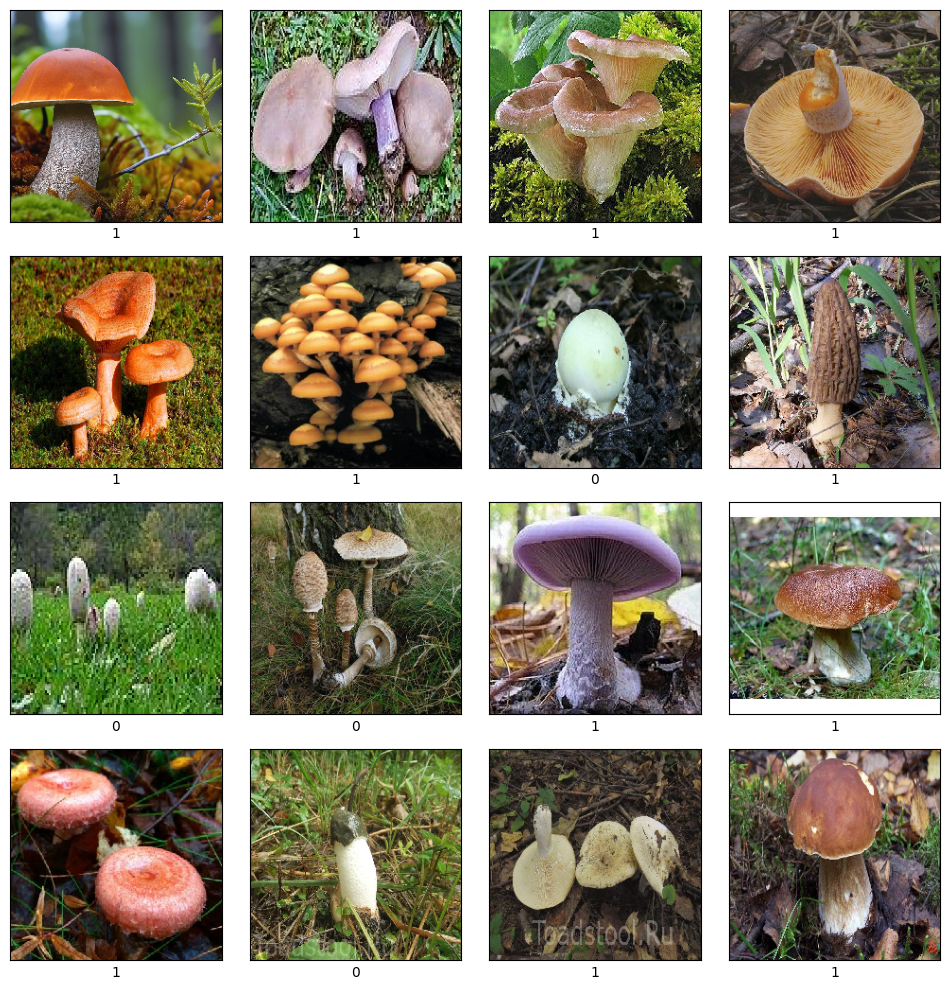

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

In [ ]:
# создаем функцию генерации батчей изображений
def load_flow(path,
              aug=True,
              dataframe_postfix=LABELS,
              directory_postfix='',
              validation_split=0.2,
              target_size=PIC_RES[:2],
              batch_size=32,
              class_mode='raw',
              subset='training',
              seed=RANDOM_STATE,
              shuffle=True):
    dataframe = pd.read_csv(path + dataframe_postfix)

    if aug: datagen = ImageDataGenerator(width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         validation_split=validation_split,
                                         rescale=1./255)
    else: datagen = ImageDataGenerator(validation_split=validation_split, rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=path + directory_postfix,
        x_col=dataframe.columns.values[0],
        y_col=dataframe.columns.values[1],
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset=subset,
        seed=seed)#,
        #shuffle=True)

    return datagen_flow

# батчи для обучения
def load_train(path, seed=RANDOM_STATE):
    return load_flow(path, seed)

# батчи для валидации
def load_valid(path, seed=RANDOM_STATE):
    return load_flow(path, subset='validation')

# создаем модель бинарной классификации (Resnet50 c дропаутом, пулингом и полносвязным слоем)
def create_model(input_shape):
    model = Sequential()
    #backbone = ResNet50(input_shape=input_shape,
    #                    weights='imagenet',
    #                    include_top=False)#,
    #                classes=2)
    model.add(ResNet50(input_shape=input_shape,
                       include_top=False))#,
                       #weights=None,
                       #classes=2))
    #backbone.trainable = False
    #for each_layer in bone.layers:
    #   each_layer.trainable=False
    #model.add(bone)
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax'))
    #model.add(Dense(1, activation='sigmoid'))
    model.compile(#optimizer='sgd',
                  optimizer=Adam(learning_rate=0.0001),
                  #loss='binary_crossentropy',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
                  #metrics=['binary_accuracy'])#,
                  #run_eagerly=True)
    print(model.summary())

    return model

# функция обучения модели
def train_model(model,
                train_data,
                valid_data,
                batch_size=32,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    model.fit(train_data,
              validation_data=valid_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

In [ ]:
# создаем тренировочный и валидационный генераторы
train_datagen = load_train(PATH, seed=RANDOM_STATE)
valid_datagen = load_valid(PATH, seed=RANDOM_STATE)

Found 853 validated image filenames.
Found 213 validated image filenames.


In [ ]:
# создаем модель
model = create_model(PIC_RES)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
None


In [ ]:
# обучаем модель
train_model(model, batch_size=BATCH_SIZE,
            train_data=train_datagen,
            valid_data=valid_datagen,
            steps_per_epoch=len(train_datagen),
            validation_steps=len(valid_datagen))

Epoch 1/10
27/27 - 64s - loss: 0.6691 - binary_accuracy: 0.6401 - val_loss: 0.4684 - val_binary_accuracy: 1.0000 - 64s/epoch - 2s/step
Epoch 2/10
27/27 - 19s - loss: 0.3424 - binary_accuracy: 0.8464 - val_loss: 1.6767 - val_binary_accuracy: 0.0000e+00 - 19s/epoch - 701ms/step
Epoch 3/10
27/27 - 20s - loss: 0.1752 - binary_accuracy: 0.9343 - val_loss: 0.8550 - val_binary_accuracy: 0.0000e+00 - 20s/epoch - 725ms/step
Epoch 4/10
27/27 - 19s - loss: 0.0982 - binary_accuracy: 0.9707 - val_loss: 0.8315 - val_binary_accuracy: 0.1643 - 19s/epoch - 690ms/step
Epoch 5/10
27/27 - 18s - loss: 0.0674 - binary_accuracy: 0.9754 - val_loss: 0.1970 - val_binary_accuracy: 1.0000 - 18s/epoch - 680ms/step
Epoch 6/10
27/27 - 20s - loss: 0.0592 - binary_accuracy: 0.9812 - val_loss: 0.3744 - val_binary_accuracy: 1.0000 - 20s/epoch - 759ms/step
Epoch 7/10
27/27 - 19s - loss: 0.0488 - binary_accuracy: 0.9836 - val_loss: 0.0689 - val_binary_accuracy: 1.0000 - 19s/epoch - 691ms/step
Epoch 8/10
27/27 - 18s - loss

In [ ]:
#model.save(PATH + 'model_1.keras')

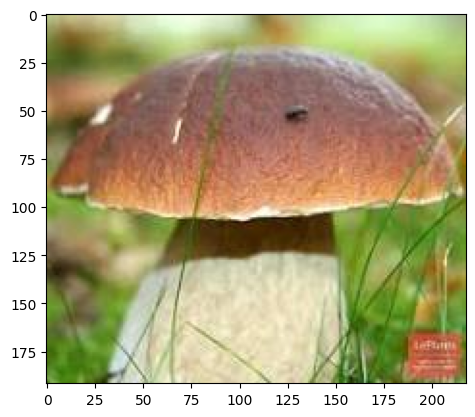

In [ ]:
# выборочный тест
img = plt.imread(PATH + 'pos_mush_2.jpg')
plt.imshow(img)
plt.show()

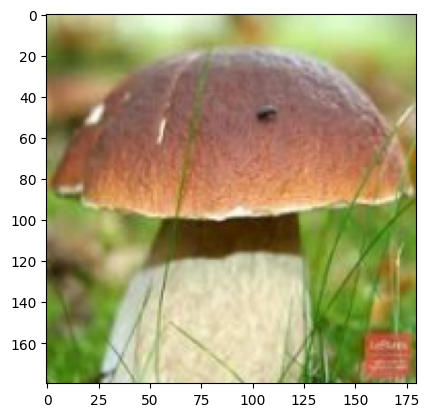

In [ ]:
img = cv2.resize(img, PIC_RES[:2], interpolation=cv2.INTER_AREA)
plt.imshow(img)
plt.show()

In [ ]:
model.predict(img.reshape((1, *PIC_RES)))
#res = model.predict(load_flow(PATH, class_mode=None, subset='training'))

1/1 [==============================] - 4s 4s/step


array([[0.0029745 , 0.99702555]], dtype=float32)

In [ ]:
# загрузка модели

CPU times: user 1min 9s, sys: 1min 20s, total: 2min 30s
Wall time: 2min 42s


In [ ]:
#model = load_model(PATH + 'model_1.keras')

1/1 [==============================] - 0s 120ms/step
CPU times: user 5min 16s, sys: 5.18 s, total: 5min 21s
Wall time: 7min 16s


In [ ]:
#preds = []

#for num in data.images:
#    pic = cv2.resize(num, PIC_RES, interpolation=cv2.INTER_AREA)
#    pic = pic.reshape((PIC_RES[:2], 1))
#    pic = np.concatenate([pic, pic, pic], axis=2)
#    pic = pic.reshape((1, *PIC_RES))
#    preds.append(model.predict(pic)[0][1])